In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import aplpy

import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/process_tools")
from cut_resize_tools import *
from Astronomy import *

In [2]:
fits_path = "/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/fits/Cygnus_sp16_vs-40_ve040_dv0.25_12CO_Tmb.fits"
integ_hdu = fits.open("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/fits/processed_fits/CygnusX_sp16_120-230_integrate_map.fits")[0]

w_high = WCS(fits_path)
hdu = fits.open(fits_path)[0]
wcs = WCS(integ_hdu.header)

raw_d = hdu.data
header = hdu.header

In [4]:
catalogue_path = '/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/cygnus_infer_catalogue.csv' # 提供されたCSVファイル
catalogue_data = pd.read_csv(catalogue_path)

# 領域確認

In [5]:
babble_region_galactic = [] # 変換後の銀河座標を格納するリスト
for index, row in catalogue_data.iterrows():
    RA_min = row['ra_min'] * u.deg # 度単位でUnitsオブジェクトを作成
    RA_max = row['ra_max'] * u.deg
    DEC_min = row['dec_min'] * u.deg
    DEC_max = row['dec_max'] * u.deg

    # 各角の赤経・赤緯座標をSkyCoordオブジェクトとして定義
    # そして銀河座標系に変換
    # RA_min, DEC_min の点
    coord_min_min = SkyCoord(ra=RA_min, dec=DEC_min, frame='icrs').galactic
    # RA_max, DEC_min の点
    coord_max_min = SkyCoord(ra=RA_max, dec=DEC_min, frame='icrs').galactic
    # RA_min, DEC_max の点
    coord_min_max = SkyCoord(ra=RA_min, dec=DEC_max, frame='icrs').galactic
    # RA_max, DEC_max の点
    coord_max_max = SkyCoord(ra=RA_max, dec=DEC_max, frame='icrs').galactic

    # 変換された銀河座標 (l, b) のリストを作成
    babble_region_galactic.append([
        [coord_min_min.l.deg, coord_min_min.b.deg], # 0: L_min, B_min
        [coord_max_min.l.deg, coord_max_min.b.deg], # 1: L_max, B_min
        [coord_min_max.l.deg, coord_min_max.b.deg], # 2: L_min, B_max
        [coord_max_max.l.deg, coord_max_max.b.deg]  # 3: L_max, B_max
    ])
print(f"babble_region_galactic len: {len(babble_region_galactic)}")


# --- babble_region_pix への変換 (修正) ---
# ループ元を babble_region_galactic に変更
babble_region_pix = []
for i in range(len(babble_region_galactic)):
    babble_region = babble_region_galactic[i] # 銀河座標のバブル領域
    region_list = []
    for j in range(len(babble_region)):
        world_coords_list = [list(babble_region[j])] # [L, B] のリスト
        
        # WCS変換。世界座標 (L, B) をピクセル座標に変換
        # origin=0 でPythonの0-based indexに対応
        region_pix_result = wcs.wcs_world2pix(world_coords_list, 0)

        # 変換結果の形状と要素数をチェックする
        if len(region_pix_result) > 0 and len(region_pix_result[0]) == 2:
            region_list.append(region_pix_result[0]) # 期待通り [x, y] を追加
        else:
            print(f"警告: bubble_num={i}, point_idx={j} のWCS変換結果が不正です: {region_pix_result}. NaNで埋めます。")
            region_list.append([np.nan, np.nan]) # NaNで埋めて、後で除外されるようにする

    babble_region_pix.append(region_list)
print(f"babble_region_pix len: {len(babble_region_pix)}")

babble_region_galactic len: 78
babble_region_pix len: 78


In [6]:
cutting_ratio = 2
data_dic = {}
data_to_cut = raw_d.copy() # raw_d からのコピー

for bubble_num in range(len(babble_region_pix)):
    all_x_coords = [p[0] for p in babble_region_pix[bubble_num]]
    all_y_coords = [p[1] for p in babble_region_pix[bubble_num]]

    # ピクセル座標の最小値と最大値を取得
    # np.min と np.max を使うことで、座標の順序に関わらず正しい矩形領域の境界を取得
    # これにより、x_max_pix < x_min_pix のような逆転を防ぎ、スライス範囲が巨大になるのを防ぐ
    x_min_pix = int(np.floor(np.min(all_x_coords)))
    x_max_pix = int(np.ceil(np.max(all_x_coords)))
    y_min_pix = int(np.floor(np.min(all_y_coords)))
    y_max_pix = int(np.ceil(np.max(all_y_coords)))

    x_center = (x_min_pix + x_max_pix) // 2 
    y_center = (y_min_pix + y_max_pix) // 2
    
    x_range = (x_max_pix - x_min_pix) // 2 * cutting_ratio
    y_range = (y_max_pix - y_min_pix) // 2 * cutting_ratio

    x_min_pix = int(x_center - x_range)
    x_max_pix = int(x_center + x_range)
    y_min_pix = int(y_center - y_range)
    y_max_pix = int(y_center + y_range)
    
    # 切り出し実行
    cutting_data = data_to_cut[:, y_min_pix:y_max_pix, x_min_pix:x_max_pix]
    pix_cood = (x_min_pix, x_max_pix, y_min_pix, y_max_pix)
    data_dic[pix_cood] = cutting_data

    # デバッグ用に切り出したデータの形状と範囲を表示してみる
    # print(f"Bubble {bubble_num}: X range [{x_min_pix}, {x_max_pix}], Y range [{y_min_pix}, {y_max_pix}], Shape: {cutting_data.shape}")

In [8]:
deleted_indices = []
filtered_list = [
    data for idx, data in enumerate(data_dic.items()) 
    if not np.all((data[1] == 0) | np.isnan(data[1]))
    or deleted_indices.append(idx)  # 削除されたインデックスを記録
]

# 削除されたインデックスを表示
print("削除されたデータのインデックス:", deleted_indices)
print("削除された数: ", len(deleted_indices))
print("残ったデータ数: ",len(filtered_list))

削除されたデータのインデックス: [4, 6, 8, 10, 11, 12, 19, 22, 24, 26, 27, 31, 33, 34, 36, 37, 38, 39, 42, 44, 45, 46, 50, 51, 53, 54, 55, 57, 59, 60, 61, 63, 64, 65, 68, 71, 73]
削除された数:  37
残ったデータ数:  41


In [9]:
remove_list = [0, 5, 8, 9, 10, 12, 17, 19, 21, 34]
filtered_list = [data for i, data in enumerate(filtered_list) if i not in remove_list]

In [10]:
mask_bubble_map = raw_d.copy()

In [12]:
for pdu in filtered_list:
    pdu = pdu[0]
    x_min, x_max, y_min, y_max = pdu[0], pdu[1], pdu[2], pdu[3]

    # 1. 対象領域をスライスで取得
    region = mask_bubble_map[:, y_min:y_max, x_min:x_max]
    
    # 2. 領域内でNaNではない要素のマスクを作成
    # np.isnan(region) は NaN の位置が True になる
    # ~ で論理反転させ、NaNで「ない」位置を True にする
    not_nan_mask = ~np.isnan(region)
    
    # 3. マスクがTrueの位置（NaNでない要素）だけを0にする
    region[not_nan_mask] = np.nan

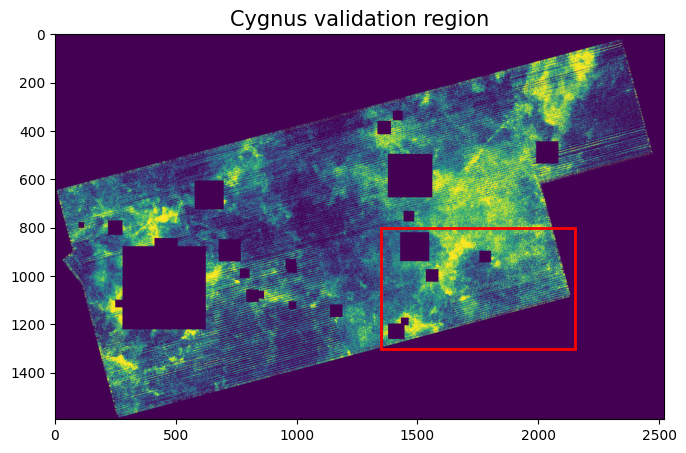

In [13]:
import matplotlib.patches as patches

val_x_min = 1350
val_x_max = 2150
val_y_min = 800
val_y_max = 1300

# 画像データの準備（NaNにする処理は削除し、そのまま描画用に集約します）
# axis=0で足し合わせているので、これをベースにします
display_data = np.nansum(mask_bubble_map, axis=0)

# 描画の準備
fig, ax = plt.subplots(figsize=(8, 5))

# 1. 画像を描画
ax.imshow(display_data, vmin=0, vmax=500)
# ※天文データの場合、origin='lower' を入れている場合はそのまま入れてください

# 2. 枠線（Rectangle）を作成
# 引数: (左上のx, 左上のy), 幅, 高さ
rect = patches.Rectangle(
    (val_x_min, val_y_min),           # 始点 (x, y)
    val_x_max - val_x_min,            # 幅 (width)
    val_y_max - val_y_min,            # 高さ (height)
    linewidth=2,                      # 線の太さ
    edgecolor='red',                  # 線の色
    facecolor='none'                  # 塗りつぶしなし（枠だけにするために必須）
)

# 3. 画像の上に枠線を追加
ax.add_patch(rect)

plt.title("Cygnus validation region", fontsize=15)

# plt.savefig("Cygnus_validation_region.png")
plt.show()

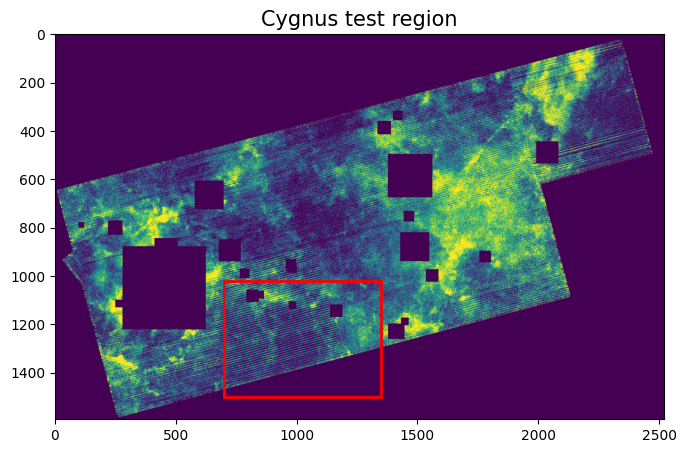

In [14]:
import matplotlib.patches as patches

test_y_min = 1020
test_y_max = 1500
test_x_min = 700
test_x_max = 1350

# 画像データの準備（NaNにする処理は削除し、そのまま描画用に集約します）
# axis=0で足し合わせているので、これをベースにします
test_map = np.nansum(mask_bubble_map, axis=0)

# 描画の準備
fig, ax = plt.subplots(figsize=(8, 5))

# 1. 画像を描画
ax.imshow(test_map, vmin=0, vmax=500)
# ※天文データの場合、origin='lower' を入れている場合はそのまま入れてください

# 2. 枠線（Rectangle）を作成
# 引数: (左上のx, 左上のy), 幅, 高さ
rect = patches.Rectangle(
    (test_x_min, test_y_min),           # 始点 (x, y)
    test_x_max - test_x_min,            # 幅 (width)
    test_y_max - test_y_min,            # 高さ (height)
    linewidth=2,                      # 線の太さ
    edgecolor='red',                  # 線の色
    facecolor='none'                  # 塗りつぶしなし（枠だけにするために必須）
)

# 3. 画像の上に枠線を追加
ax.add_patch(rect)

plt.title("Cygnus test region", fontsize=15)

# plt.savefig("Cygnus_test_region.png")
plt.show()